# Intrusion Detection System Analysis, VAEs, and Prediction

#### Connor McManigal, Aaron Mui, Rishabh Verma, and Peyton Politewicz

## Imports and Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colormaps
from mpl_toolkits.mplot3d import Axes3D
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from VAEmodel import VariationalAutoEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from tqdm import tqdm

In [3]:
df = pd.read_csv('RT_IOT2022.csv')
x = df.drop(['Attack_type'], axis = 1)
y = df[['Attack_type']]

print("Data Shape with Aggregates\n")
print("Rows:", x.shape[0])
print("Features:", x.shape[1])

Data Shape with Aggregates

Rows: 209959
Features: 83


In [4]:
X = x.filter(regex='^((?!max|min|avg|std).)*$')

print("Data Shape without Aggregates\n")
print("Rows:", X.shape[0])
print("Features:", X.shape[1])
X.head()

Data Shape without Aggregates

Rows: 209959
Features: 47


,id.orig_p,id.resp_p,proto,service,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,...,bwd_bulk_bytes,fwd_bulk_packets,bwd_bulk_packets,fwd_bulk_rate,bwd_bulk_rate,active.tot,idle.tot,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size
0,31004,53,udp,dns,0.005875,1,1,1,1,170.209561,...,0.0,0.0,0.0,0.000000,0.000000,5.875111e+03,0.0,0,0,0
1,54222,443,tcp,-,7.807541,159,144,134,38,20.364926,...,15569.5,62.5,15.5,10096.717546,33346.967364,7.807541e+06,0.0,11890,3216,11890
2,48618,80,tcp,http,0.216894,7,7,1,2,32.273807,...,0.0,0.0,0.0,0.000000,0.000000,3.060679e+05,0.0,29200,29200,1065
3,8,0,icmp,-,0.014496,10,10,10,10,689.841286,...,0.0,0.0,0.0,0.000000,0.000000,1.449609e+04,0.0,0,0,0
4,54222,443,tcp,-,8.797776,158,176,133,45,17.959084,...,15570.5,124.0,19.0,10251.481385,32467.560574,8.797776e+06,0.0,11890,3220,11890


## Exploratory Data Analysis

In [120]:
# get counts of targets
y.value_counts()

Attack_type               
DOS_SYN_Hping                 94659
Alexa                         86842
Thing_Speak                    8108
ARP_poisioning                 7750
MQTT_Publish                   4146
NMAP_UDP_SCAN                  2590
NMAP_XMAS_TREE_SCAN            2010
NMAP_OS_DETECTION              2000
NMAP_TCP_scan                  1002
DDOS_Slowloris                  534
Wipro_bulb                      253
Metasploit_Brute_Force_SSH       37
NMAP_FIN_SCAN                    28
Name: count, dtype: int64

C:\Users\risha\AppData\Local\Temp\ipykernel_34216\961355872.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




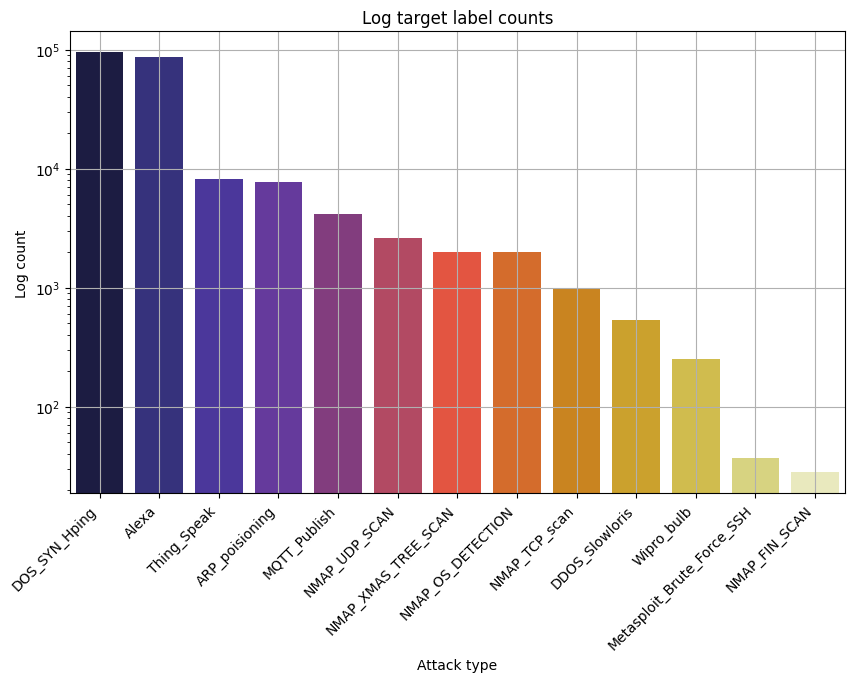

In [121]:
plt.figure(figsize = (10,6))
sns.countplot(data = y, x = y['Attack_type'], order = y['Attack_type'].value_counts().index, palette = 'CMRmap')
plt.yscale('log')
plt.ylabel('Log count')
plt.xlabel('Attack type')
plt.title('Log target label counts')
plt.xticks(rotation = 45, ha = 'right')
plt.grid()
plt.show()

In [122]:
# get counts of protocols
X['proto'].value_counts()

proto
tcp     190243
udp      17655
icmp      2061
Name: count, dtype: int64

In [123]:
# get counts of network services
X['service'].value_counts()

service
-         164484
ssl        20935
dns        14670
http        5471
mqtt        4132
ntp          128
dhcp          66
irc           43
ssh           28
radius         2
Name: count, dtype: int64

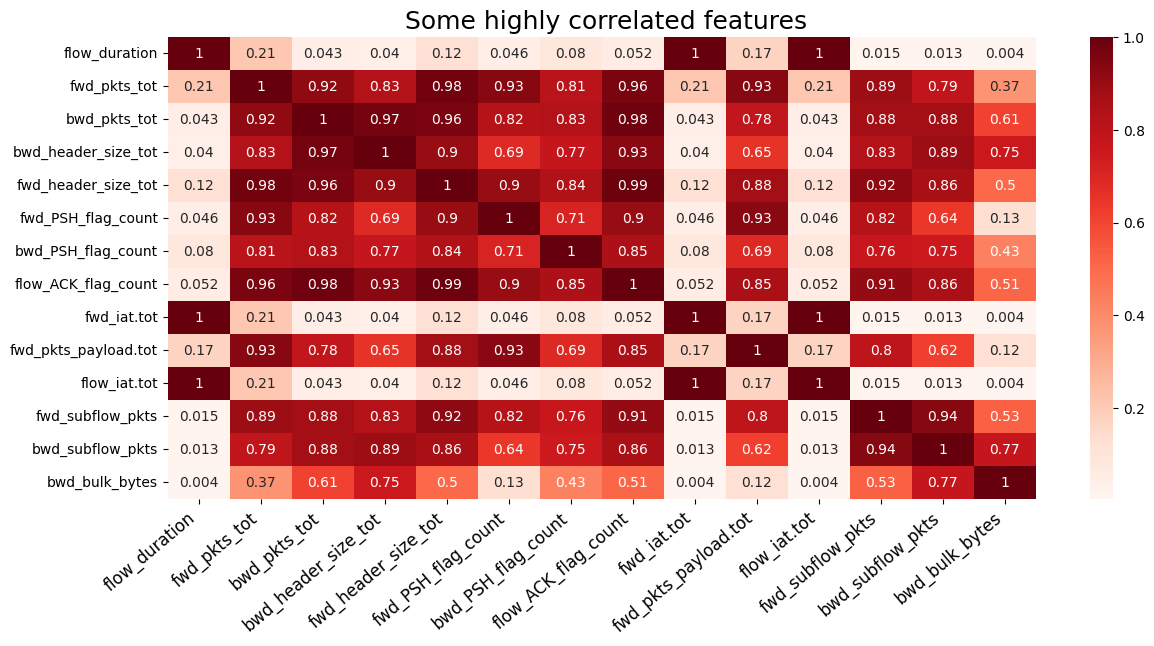

In [5]:
X_filter = X[['flow_duration', 'fwd_pkts_tot', 'bwd_pkts_tot', 'bwd_header_size_tot', 'fwd_header_size_tot', 'fwd_PSH_flag_count', 
                'bwd_PSH_flag_count', 'flow_ACK_flag_count', 'fwd_iat.tot', 'fwd_pkts_payload.tot', 'flow_iat.tot', 'fwd_subflow_pkts', 
                'bwd_subflow_pkts', 'bwd_bulk_bytes']]
X_corr = X_filter.corr()

plt.figure(figsize=(14,6))
sns.heatmap(X_corr, annot = True, cmap = 'Reds')
plt.title(' Some highly correlated features', fontsize = 18)
plt.xticks(rotation = 40, ha = 'right', fontsize = 12)
plt.show()

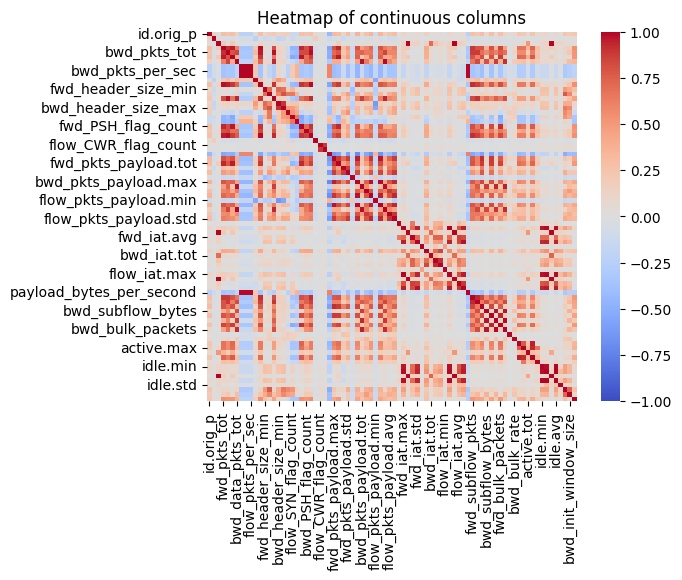

In [125]:
full_corr_matrix = x.drop(["proto", "service", "bwd_URG_flag_count"], axis=1).corr()
sns.heatmap(full_corr_matrix, cmap='coolwarm', cbar=True, vmin=-1, vmax=1, square=True)
plt.title("Heatmap of continuous columns")
plt.show()

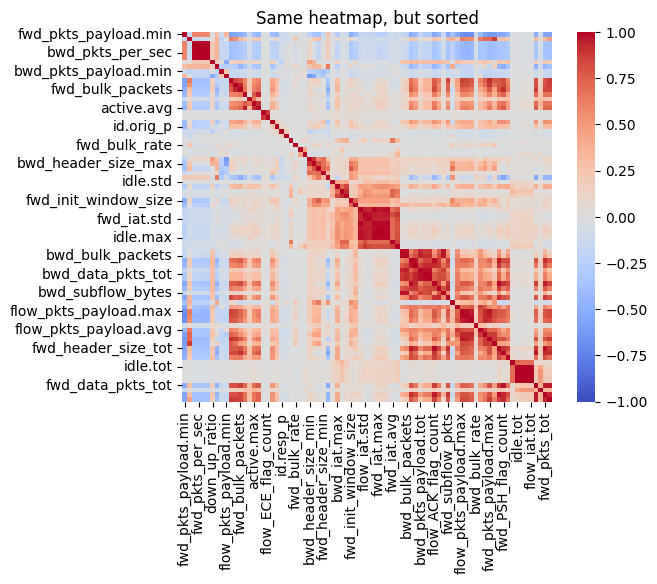

In [126]:
# Use agglomerative clustering on the heatmap
# Result is non-deterministic, so I saved a good value

#from scipy.cluster.hierarchy import linkage, leaves_list
#linkage_matrix = linkage(corr_matrix, method='complete')
#ordered_indices = leaves_list(linkage_matrix)

ordered_indices = np.array([26,29,56,7,8,9,10,19,31,36,59,61,63,67,71,68,70,24,25,79,0,1,23,41,65,46,51,15,16,13,12,18,76,47,49,50,77,78,72,55,45,75,42,52,73,44,54,62,64,4,14,33,6,38,22,58,60,57,17,34,37,32,35,66,39,40,27,30,11,20,21,48,74,43,2,53,5,69,3,28])
ordered_corr_matrix = full_corr_matrix.iloc[ordered_indices, ordered_indices]

sns.heatmap(ordered_corr_matrix, cmap='coolwarm', cbar=True, vmin=-1, vmax=1, square=True)
plt.title("Same heatmap, but sorted")
plt.show()

In [127]:
import plotly.graph_objs as go
import plotly.express as px

fig = px.imshow(np.round(np.abs(ordered_corr_matrix), 2),
                text_auto = True,
                labels = dict(color="Abs(Correlation)"),
                x = ordered_corr_matrix.columns,
                y = ordered_corr_matrix.columns,
                color_continuous_scale = "viridis",
                title="Interactive sorted heatmap")

fig.update_traces(hovertemplate="<b>%{x}</b> vs <b>%{y}</b><br>Abs(correlation): %{z:.2f}<extra></extra>")
fig.show()

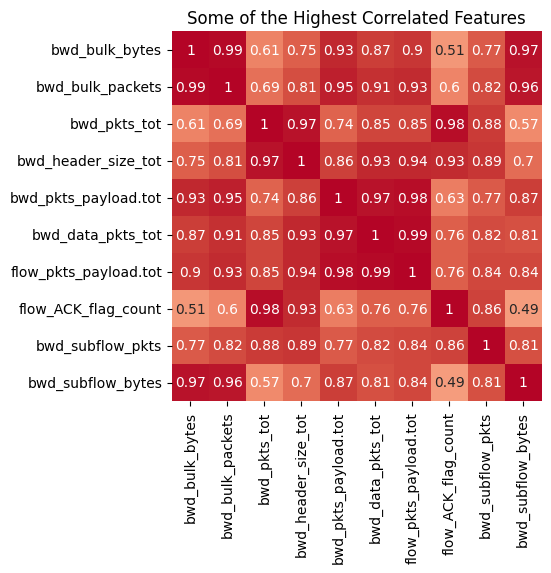

In [128]:
cols = range(47,57)
sub_corr_matrix = ordered_corr_matrix.iloc[cols, cols]
sns.heatmap(sub_corr_matrix, cmap='coolwarm', cbar=False, vmin=-1, vmax=1, annot=True, square=True)
plt.title('Some of the Highest Correlated Features')
plt.show()

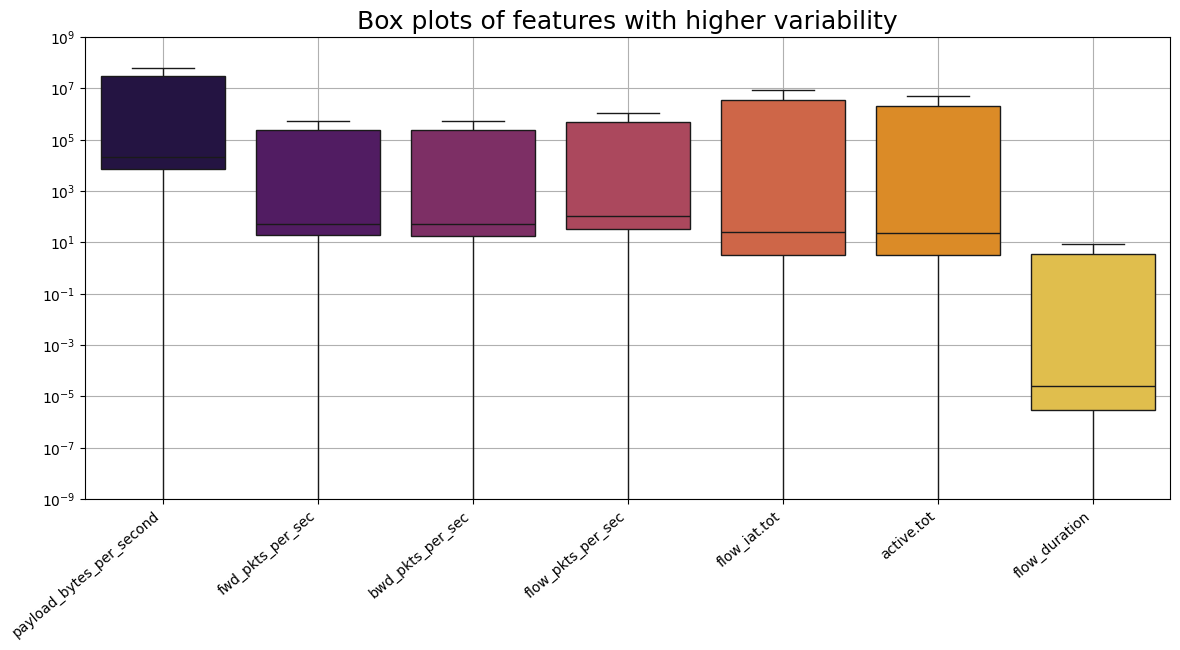

In [129]:
# visualize box plots of features with higher variability
X_higher_variability = X[['payload_bytes_per_second', 'fwd_pkts_per_sec', 'bwd_pkts_per_sec', 'flow_pkts_per_sec', 'flow_iat.tot', 'active.tot', 'flow_duration']]

plt.figure(figsize = (14,6))
sns.boxplot(data = X_higher_variability, showfliers = False, palette = 'inferno')
plt.yscale('log')
plt.ylim(10**-9, 10**9)
plt.xticks(rotation = 40, ha = 'right')
plt.title('Box plots of features with higher variability', fontsize  = 18)
plt.grid()
plt.show()

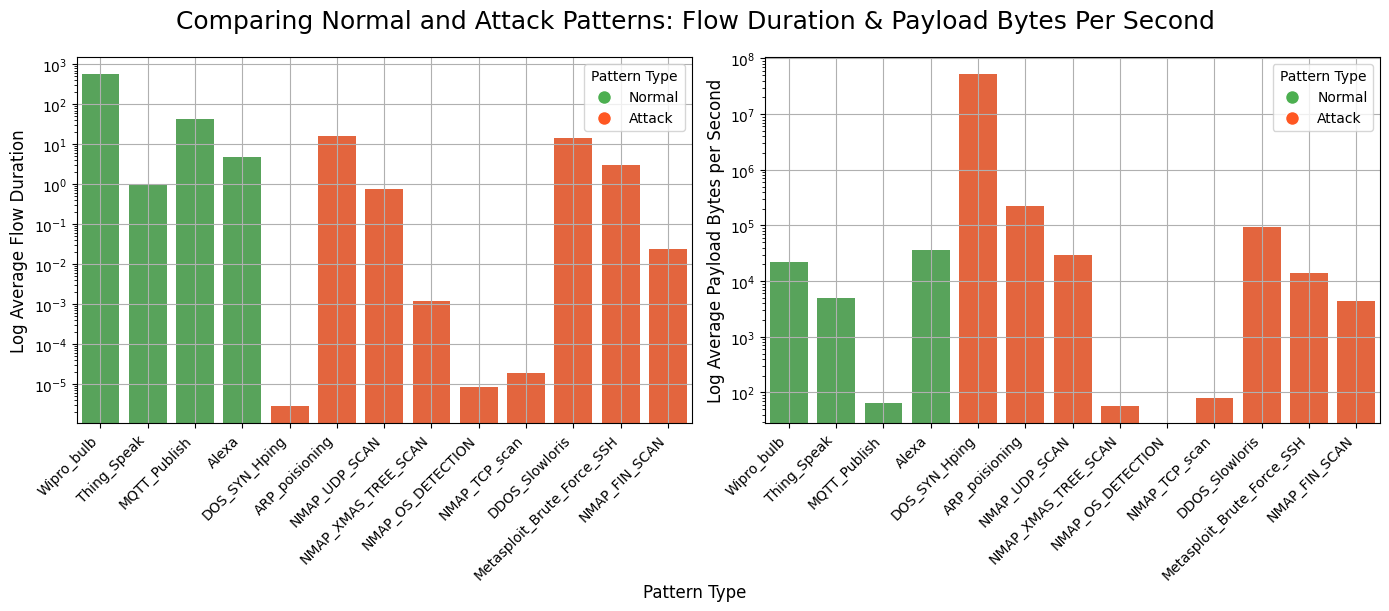

In [7]:
# average flow duration and payload bytes per second for normal patterns
full_data = pd.concat([X,y], axis = 1)

normal_types = [
    'Wipro_bulb',
    'Thing_Speak',
    'MQTT_Publish',
    'Alexa'
]

attack_types = [
    'DOS_SYN_Hping',
    'ARP_poisioning',
    'NMAP_UDP_SCAN',
    'NMAP_XMAS_TREE_SCAN',
    'NMAP_OS_DETECTION',
    'NMAP_TCP_scan',
    'DDOS_Slowloris',
    'Metasploit_Brute_Force_SSH',
    'NMAP_FIN_SCAN'
]
types = normal_types + attack_types

fig, axes = plt.subplots(1,2, figsize = (14,6))

for normal in normal_types:
    normal_patterns = full_data[full_data['Attack_type'] == normal]
    avg_flow_duration = normal_patterns['flow_duration'].mean()
    sns.barplot(x = [normal], y = [avg_flow_duration], ax = axes[0], color = '#4CAF50')

for attack in attack_types:
    attack_patterns = full_data[full_data['Attack_type'] == attack]
    avg_flow_duration = attack_patterns['flow_duration'].mean()
    sns.barplot(x = [attack], y = [avg_flow_duration], ax = axes[0], color = '#FF5722')

legend_labels = ['Normal', 'Attack']
colors = ['#4CAF50', '#FF5722']
legend_handles = [plt.Line2D([0], [0], marker = 'o', color = 'w', label = label, markerfacecolor = color, markersize = 10) for label, color in zip(legend_labels, colors)]

#axes[0].set_title('Log Average Flow Duration', fontsize = 13)
axes[0].set_ylabel('Log Average Flow Duration', fontsize = 12)
axes[0].set_yscale('log')
axes[0].grid()
axes[0].set_xticks(range(len(types)))
axes[0].set_xticklabels(types, rotation = 45, ha = 'right')
axes[0].legend(title = 'Pattern Type', handles = legend_handles, loc = 'upper right')


for normal in normal_types:
    normal_patterns = full_data[full_data['Attack_type'] == normal]
    avg_payload = normal_patterns['payload_bytes_per_second'].mean()
    sns.barplot(x = [normal], y = [avg_payload], ax = axes[1], color = '#4CAF50')

for attack in attack_types:
    attack_patterns = full_data[full_data['Attack_type'] == attack]
    avg_payload = attack_patterns['payload_bytes_per_second'].mean()
    sns.barplot(x = [attack], y = [avg_payload], ax = axes[1], color = '#FF5722')

#axes[1].set_title('Log Average Payload Bytes per Second', fontsize = 13)
axes[1].set_ylabel('Log Average Payload Bytes per Second', fontsize = '12')
axes[1].set_yscale('log')
axes[1].grid()
axes[1].set_xticks(range(len(types)))
axes[1].set_xticklabels(types, rotation = 45, ha = 'right')
axes[1].legend(title = 'Pattern Type', handles = legend_handles, loc = 'upper right')

plt.suptitle('Comparing Normal and Attack Patterns: Flow Duration & Payload Bytes Per Second', fontsize = 18)

fig.text(0.5, 0.0001, 'Pattern Type', ha = 'center', fontsize = 12)
plt.tight_layout()
plt.show()

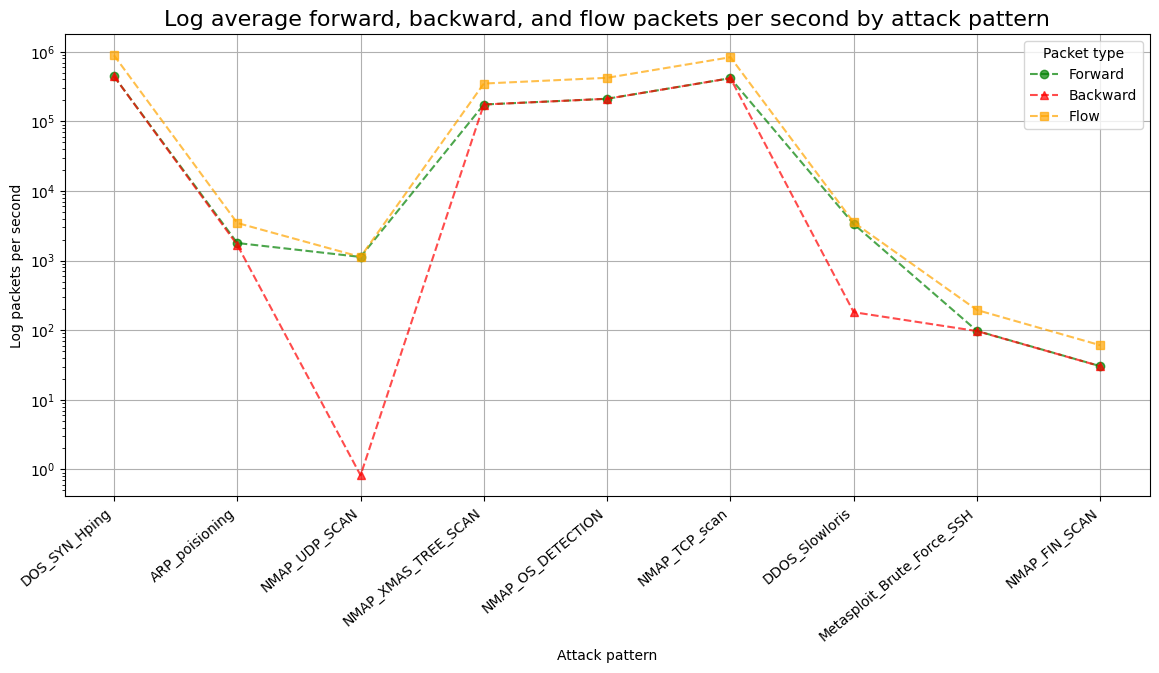

In [131]:
# forward, backward, and flow packets per second by Attack Pattern
fwd = []
bwd = []
flow = []

plt.figure(figsize = (14, 6))

for attack in attack_types:
    attack_patterns = full_data[full_data['Attack_type'] == attack]
    avg_fwd_pkts = attack_patterns['fwd_pkts_per_sec'].mean()
    fwd.append(avg_fwd_pkts)
    avg_bwd_pkts = attack_patterns['bwd_pkts_per_sec'].mean()
    bwd.append(avg_bwd_pkts)
    avg_flow_pkts = attack_patterns['flow_pkts_per_sec'].mean()
    flow.append(avg_flow_pkts)

plt.plot(attack_types, fwd, label = 'Forward',  linestyle = '--', marker = 'o', color = 'green', alpha = 0.7)
plt.plot(attack_types, bwd, label = 'Backward', linestyle = '--', marker = '^', color = 'red', alpha = 0.7)
plt.plot(attack_types, flow, label = 'Flow',  linestyle = '--', marker = 's', color = 'orange', alpha = 0.7)
plt.title('Log average forward, backward, and flow packets per second by attack pattern', fontsize = 16)
plt.xlabel('Attack pattern')
plt.ylabel('Log packets per second')
plt.xticks(rotation = 40, ha = 'right')
plt.legend(title = "Packet type")
plt.grid()
plt.yscale('log')
plt.show()

## Variational Autoencoder Training Preparation

In [8]:
# begin preprocessing
df = pd.read_csv('RT_IOT2022.csv')
df = df.filter(regex='^((?!max|min|avg|std).)*$')
df = df.drop(columns = ['id.orig_p', 'id.resp_p']) # drop IDs, unnecessary

# one-hot encode categoricals and standardize numerics
cat_cols = ['proto', 'service']
quant_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers = [
        ('quant', MinMaxScaler(), quant_cols),
        ('cat', OneHotEncoder(), cat_cols)
    ], 
    remainder = 'passthrough')

df_processed = preprocessor.fit_transform(df)
column_names = quant_cols + preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols).tolist()
column_names += df.columns.drop(quant_cols + cat_cols).tolist()
df = pd.DataFrame(df_processed, columns=column_names)
df.columns

Index(['flow_duration', 'fwd_pkts_tot', 'bwd_pkts_tot', 'fwd_data_pkts_tot',
       'bwd_data_pkts_tot', 'fwd_pkts_per_sec', 'bwd_pkts_per_sec',
       'flow_pkts_per_sec', 'down_up_ratio', 'fwd_header_size_tot',
       'bwd_header_size_tot', 'flow_FIN_flag_count', 'flow_SYN_flag_count',
       'flow_RST_flag_count', 'fwd_PSH_flag_count', 'bwd_PSH_flag_count',
       'flow_ACK_flag_count', 'fwd_URG_flag_count', 'bwd_URG_flag_count',
       'flow_CWR_flag_count', 'flow_ECE_flag_count', 'fwd_pkts_payload.tot',
       'bwd_pkts_payload.tot', 'flow_pkts_payload.tot', 'fwd_iat.tot',
       'bwd_iat.tot', 'flow_iat.tot', 'payload_bytes_per_second',
       'fwd_subflow_pkts', 'bwd_subflow_pkts', 'fwd_subflow_bytes',
       'bwd_subflow_bytes', 'fwd_bulk_bytes', 'bwd_bulk_bytes',
       'fwd_bulk_packets', 'bwd_bulk_packets', 'fwd_bulk_rate',
       'bwd_bulk_rate', 'active.tot', 'idle.tot', 'fwd_init_window_size',
       'bwd_init_window_size', 'fwd_last_window_size', 'proto_icmp',
       'pr

In [9]:
# convert targets to binary(0/1)
normal_types = ['Wipro_bulb', 'Thing_Speak', 'MQTT_Publish', 'Alexa']

attack_types = [
    'DOS_SYN_Hping', 'ARP_poisioning', 'NMAP_UDP_SCAN', 'NMAP_XMAS_TREE_SCAN', 'NMAP_OS_DETECTION',
    'NMAP_TCP_scan', 'DDOS_Slowloris', 'Metasploit_Brute_Force_SSH','NMAP_FIN_SCAN'
]

df['label'] = df['Attack_type'].apply(lambda x: 0 if x in normal_types else 1)
normal = df[df['label'] == 0]
attack = df[df['label'] == 1]

# split the data and stratify by the normal trace types
train_data, validate_normal = train_test_split(normal, test_size = 0.2, stratify = normal['Attack_type'], random_state = 21)
test_data = pd.concat([validate_normal, attack])

print('Normal pattern in training size:', train_data.shape[0])
print('Normal pattern in testing size:', validate_normal.shape[0], '\n')
print('Overall training data size:', train_data.shape[0])
print('Overall testing data size:', test_data.shape[0])

Normal pattern in training size: 79479
Normal pattern in testing size: 19870 

Overall training data size: 79479
Overall testing data size: 130480


In [134]:
train_data['label'].value_counts()

label
0    79479
Name: count, dtype: int64

In [135]:
test_data['label'].value_counts()

label
1    110610
0     19870
Name: count, dtype: int64

In [10]:
# drop training labels and attack types
train_data_labeled = train_data.copy()
train_data = train_data.drop(columns = ['Attack_type', 'label'])

## VAE Training on Normal Network Trace Patterns

Bayesian Optimization Hyperparameter considerations:
- number of hidden units
- latent space dimensionality
- activation functions (ReLU, LeakyReLU, ELU)
- learning rate
- batch normalization
- regularization?

Other considerations/ideas:
- still going to use mixture models, perhaps before VAE on entire dataset with attack label coloring?
- how many epochs(looks like plateau after 20-30)?
- train a baseline to compare to with less latent dimensions?
- visualization types (loss over training/latent space visualization)

In [12]:
# set up for training VAE
train_data = train_data.astype('float32')
train = torch.from_numpy(train_data.values).float()
train_dataset = TensorDataset(train)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)


In [11]:
# set up for visualizing ELBO loss
from IPython.display import clear_output

def plot_loss(loss):
    epoch = len(loss)
    plt.plot(1+np.arange(epoch), loss, marker='o', color='red')
    plt.ylim(bottom=0)
    plt.title('ELBO Loss during training')
    plt.xlabel('Epoch')
    plt.ylabel('ELBO Loss')
    plt.grid()

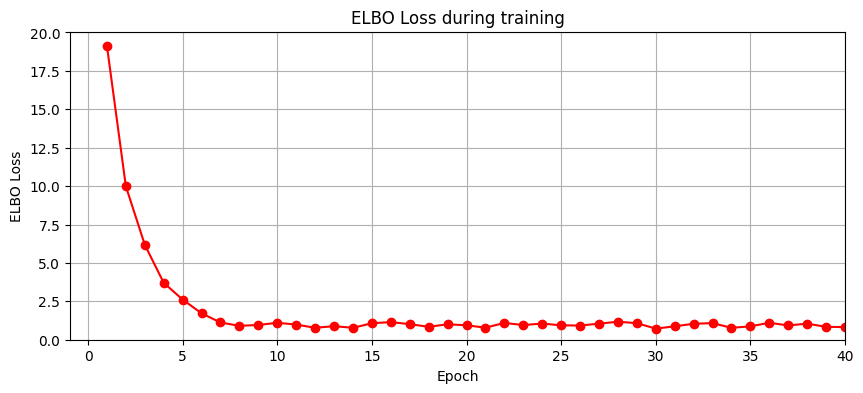

Epoch [40/40], ELBO Loss: 0.8244


In [20]:
# train VAE
input_dim = train.shape[1]
# latent dim should be less than feature dim
vae = VariationalAutoEncoder(input_dim, z_dim=5)
optimizer = optim.Adam(vae.parameters(), lr = 1e-5)
num_epochs = 40
elbo_losses = []

for epoch in range(num_epochs):
    for data in train_loader:
        data = data[0]
        optimizer.zero_grad()
        reconstructed, mu, sigma = vae(data)
        loss = vae.elbo_loss_function(reconstructed, data, mu, sigma)
        loss.backward()
        optimizer.step()
    elbo_losses.append(loss.item())

    # See ELBO during training
    clear_output(wait=True)
    plt.figure(figsize=(10,4))
    plot_loss(elbo_losses)
    plt.xlim(right=num_epochs)
    plt.show()

    print(f'Epoch [{epoch + 1}/{num_epochs}], ELBO Loss: {loss.item():.4f}')

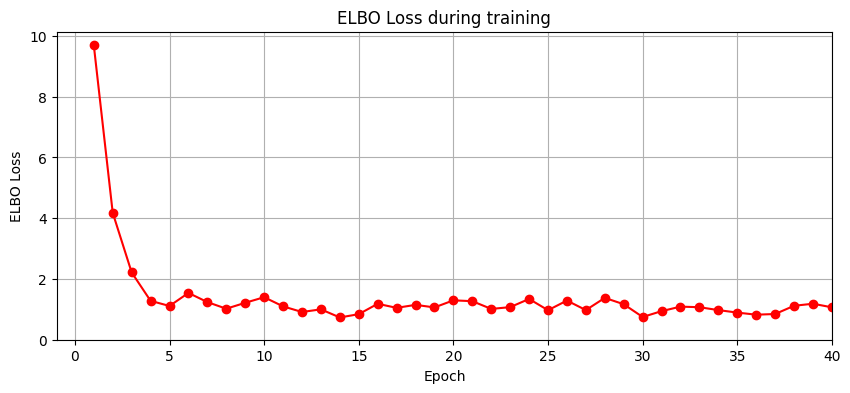

Epoch [40/40], ELBO Loss: 1.0667


In [32]:
'''
VAE trained on attack + normal.
'''
df_unlabel=df.copy()
df_unlabel.drop(columns=['Attack_type', 'label'], inplace=True)
# set up for training VAE
df_unlabel = df_unlabel.astype('float32')
full_train = torch.from_numpy(df_unlabel.values).float()
full_train_dataset = TensorDataset(full_train)
batch_size = 64
train_loader = DataLoader(full_train_dataset, batch_size = batch_size, shuffle = True)

# train VAE
input_dim = full_train.shape[1]
# latent dim should be less than feature dim
vae = VariationalAutoEncoder(input_dim, z_dim=5)
optimizer = optim.Adam(vae.parameters(), lr = 1e-5)
num_epochs = 40
elbo_losses = []

for epoch in range(num_epochs):
    for data in train_loader:
        data = data[0]
        optimizer.zero_grad()
        reconstructed, mu, sigma = vae(data)
        loss = vae.elbo_loss_function(reconstructed, data, mu, sigma)
        loss.backward()
        optimizer.step()
    elbo_losses.append(loss.item())

    # See ELBO during training
    clear_output(wait=True)
    plt.figure(figsize=(10,4))
    plot_loss(elbo_losses)
    plt.xlim(right=num_epochs)
    plt.show()

    print(f'Epoch [{epoch + 1}/{num_epochs}], ELBO Loss: {loss.item():.4f}')


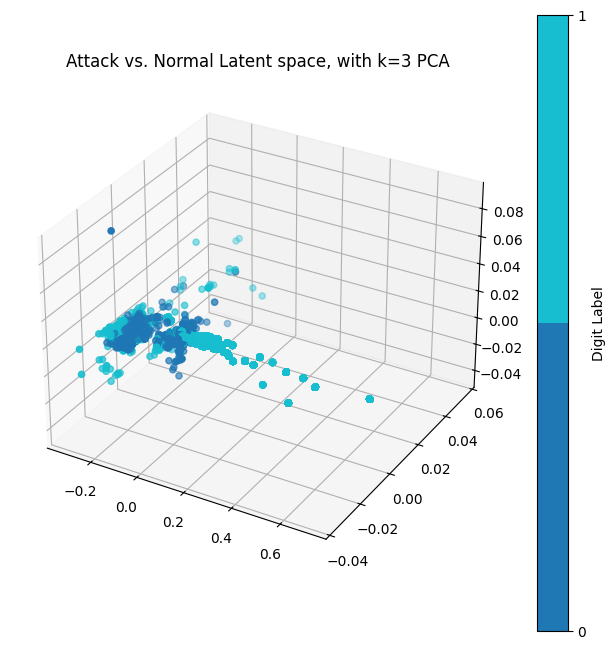

In [34]:
'''
Plot for normal vs attack latent representation
'''
# visualize latent dimensions with PCA (probably intractable!)
eval_data_labels = df['label']
eval_data_no_labels = df.drop(['Attack_type', 'label'], axis=1)
    
eval_data_loader = DataLoader(torch.from_numpy(eval_data_no_labels.astype('float32').values).float(), batch_size = eval_data_no_labels.shape[0], shuffle=False)

data = next(iter(eval_data_loader))

_, mu, _ = vae(data)

latent_representations = mu.detach().numpy()


pca = PCA(n_components=3)
pca_result = pca.fit_transform(latent_representations)

# Plot the 3 highest dimensions in 3D
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Use the labels to color the points (optional)
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(eval_data_labels)
#
unique_labels = np.unique(eval_data_labels)
num_unique_labels = len(unique_labels)
colors = plt.get_cmap('tab10', num_unique_labels)

scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=integer_labels, cmap=colors)

colorbar = fig.colorbar(scatter, ax=ax, label='Digit Label')
colorbar.set_ticks(np.arange(num_unique_labels))
colorbar.set_ticklabels(unique_labels)

plt.title("Attack vs. Normal Latent space, with k=3 PCA")
plt.show()

In [44]:
# For plotting the loss over time AFTER training
#plt.figure(figsize = (10,4))
#plot_loss(elbo_losses)
#plt.show()

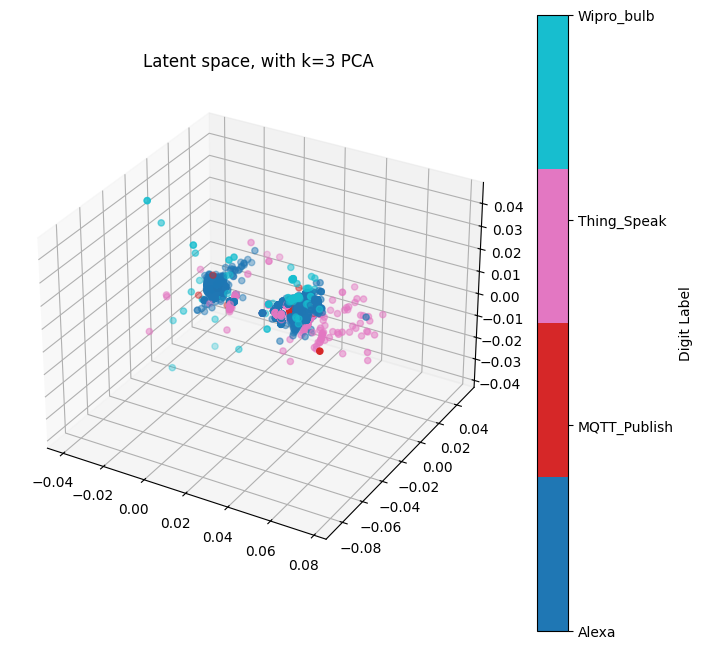

In [21]:
# visualize latent dimensions with PCA (probably intractable!)
eval_data_labels = train_data_labeled['Attack_type']
eval_data_no_labels = train_data_labeled.drop(['Attack_type', 'label'], axis=1)
    
eval_data_loader = DataLoader(torch.from_numpy(eval_data_no_labels.astype('float32').values).float(), batch_size = eval_data_no_labels.shape[0], shuffle=False)

data = next(iter(eval_data_loader))

_, mu, _ = vae(data)

latent_representations = mu.detach().numpy()


pca = PCA(n_components=3)
pca_result = pca.fit_transform(latent_representations)

# Plot the 3 highest dimensions in 3D
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Use the labels to color the points (optional)
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(eval_data_labels)
#
unique_labels = np.unique(eval_data_labels)
num_unique_labels = len(unique_labels)
colors = plt.get_cmap('tab10', num_unique_labels)

scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=integer_labels, cmap=colors)

colorbar = fig.colorbar(scatter, ax=ax, label='Digit Label')
colorbar.set_ticks(np.arange(num_unique_labels))
colorbar.set_ticklabels(unique_labels)

plt.title("Latent space, with k=3 PCA")
plt.show()

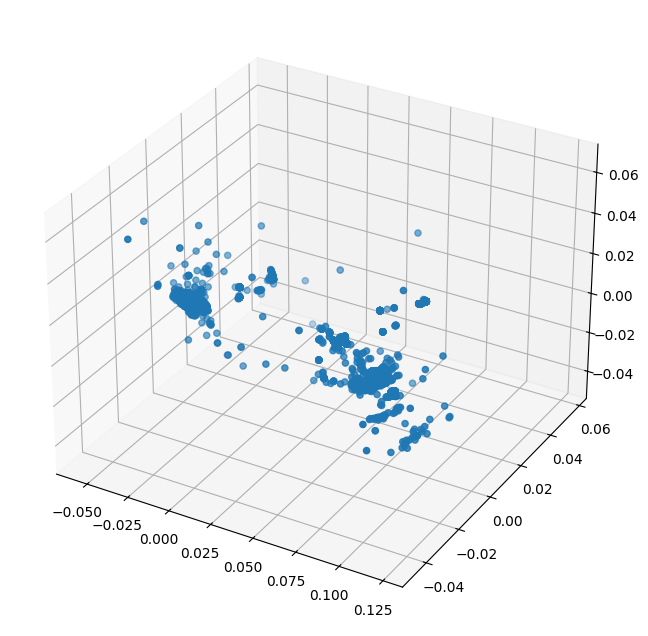

In [81]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

latent_representations = []
for data in train_loader:
    data = data[0]
    _, mu, _ = vae(data)
    latent_representations.append(mu.detach().numpy())
latent_representations = np.concatenate(latent_representations, axis=0)

pca = PCA(n_components=3)
pca_result = pca.fit_transform(latent_representations)

# Plot the 3 highest dimensions in 3D
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Use the labels to color the points (optional)

scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2])


In [ ]:
# visualize latent dimensions with t-SNE (probably intractable!)
latent_representations = []
for data in train_loader:
    data = data[0]
    _, mu, _ = vae(data)
    latent_representations.append(mu.detach().numpy())



latent_representations = np.concatenate(latent_representations, axis = 0)
tsne = TSNE(n_components = 2, random_state = 21, verbose=1)
# THIS TAKES WAY TOO LONG TO RUN
latent_tsne = tsne.fit_transform(latent_representations)

plt.figure(figsize=(8, 6))
plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1])
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('Latent Space Visualization (t-SNE)')
plt.show()

## VAE Testing Analysis

In [14]:
test_data = test_data.drop(columns = ['Attack_type', 'label'])

In [15]:
# set up test specifications
test_data = test_data.astype('float32')
test = torch.from_numpy(test_data.values).float()
test_dataset = TensorDataset(test)
batch_size = 64
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [16]:
# test vae model performance (needs work, in early steps)
vae.eval()
test_loss = 0.0
num_samples = 0

with torch.no_grad():
    for data in test_loader:
        data = data[0]
        reconstructed, mu, sigma = vae(data)
        batch_loss = vae.elbo_loss_function(reconstructed, data, mu, sigma)
        test_loss += batch_loss.item() * data.size(0)
        num_samples += data.size(0)

avg_test_loss = test_loss / num_samples
print(f'Average Test ELBO Loss: {avg_test_loss:.4f}')

Average Test ELBO Loss: 2.1735
